Imports

In [228]:
import pandas 
import numpy
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

Read data

In [229]:
df_20 = pandas.read_csv("Data/20_dana.csv")
df_40 = pandas.read_csv("Data/40_dana.csv")
df_130 = pandas.read_csv("Data/130_dana.csv")

In [255]:
df_300 = pandas.read_csv("Data/quality_controls2.csv")
cols = ['frequency', 'costType', 'risk_id', 'created_at']
df_300 = df_300[cols]
df_300['date'] = pandas.to_datetime(df_300['created_at'])
df_300['date'] = df_300['date'].dt.date


unit_price = {
    'finishing': 5,
    'scrap':     50
}
df_300['unit_price'] = df_300['costType'].map(unit_price) # type: ignore
df_300['price'] = df_300['frequency'] * df_300['unit_price']

df_300 = (
    df_300
    .groupby(['date','risk_id'], as_index=False)['price']
    .sum()
)
df_300 = df_300.set_index('date')

df_risk1 = df_300[df_300['risk_id'] == 3]
# 1. parameters
days        = len(df_risk1)
start_price = 1000
end_price   = 3000     # e.g. +20% over the period
noise_pct   = 0.05                     # ±2% noise each day
rng         = numpy.random.default_rng(123)

# 2. build the trend
trend = numpy.linspace(start_price, end_price, days)

# 3. additive noise ∼ Normal(0, noise_pct*start_price)
noise = rng.normal(loc=0, scale=start_price*noise_pct, size=days)

# 4. combine and clip at zero
df_risk1['price'] = numpy.clip(trend + noise, a_min=0, a_max=None)

/tmp/ipykernel_541/1852282425.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_risk1['price'] = numpy.clip(trend + noise, a_min=0, a_max=None)


SES - Simple exponential smoothing

/usr/local/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


483
Total forecasted price: 1,423,583.11


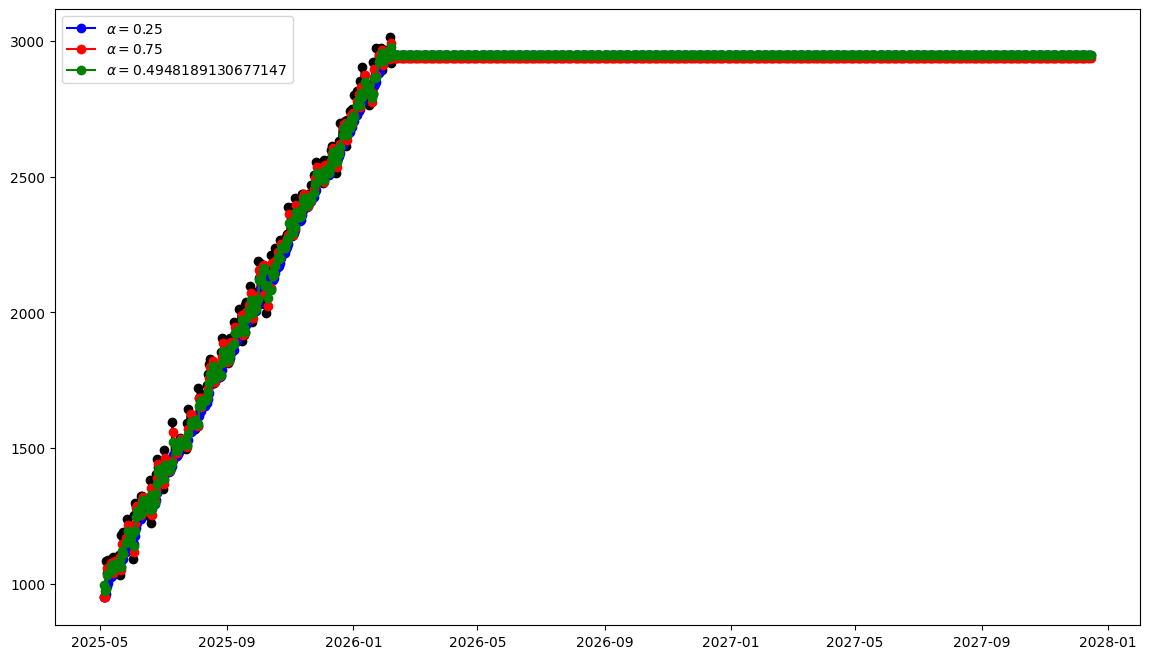

In [256]:
project_start_date = datetime.strptime("2025-05-04", "%Y-%m-%d")
project_end_date = datetime.strptime("2027-05-04", "%Y-%m-%d")
current_date = datetime.strptime("2025-06-27", "%Y-%m-%d")

count_excluding_end = pandas.bdate_range(start=current_date, end=project_end_date).size

train = df_risk1['price']   
model_1  = SimpleExpSmoothing(train).fit(smoothing_level=0.25,optimized=False)   
model_2  = SimpleExpSmoothing(train).fit(smoothing_level=0.75,optimized=False)       

# # alpha oznacava odnos pravih i prediktovanih podataka u algoritmu. 25% znaci da je 25% vrednost predikcije a 75% realna vrednost.
fcast1 = model_1.forecast(count_excluding_end).rename(r"$\alpha=0.25$")
fcast2 = model_2.forecast(count_excluding_end).rename(r"$\alpha=0.75$")

fit3 = SimpleExpSmoothing(train, initialization_method = "heuristic").fit()
fcast3 = fit3.forecast(count_excluding_end).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])

print(count_excluding_end)

plt.figure(figsize=(14, 8))
plt.plot(train, marker="o", color="black")
plt.plot(model_1.fittedvalues, marker="o", color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(model_2.fittedvalues, marker="o", color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(fit3.fittedvalues, marker="o", color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

total_fcast3 = fcast3.sum()
print(f"Total forecasted price: {total_fcast3:,.2f}")

Linear regression

            risk_id        price  weekday
date                                     
2025-05-04        0     0.000000        6
2025-05-05        3   950.543932        0
2025-05-06        3   991.660919        1
2025-05-07        3  1084.496766        2
2025-05-08        3  1039.849475        3
2025-05-09        3  1086.212550        4
2025-05-10        0     0.000000        5
2025-05-11        0     0.000000        6
2025-05-12        3  1079.106446        0
2025-05-13        3  1028.478325        1


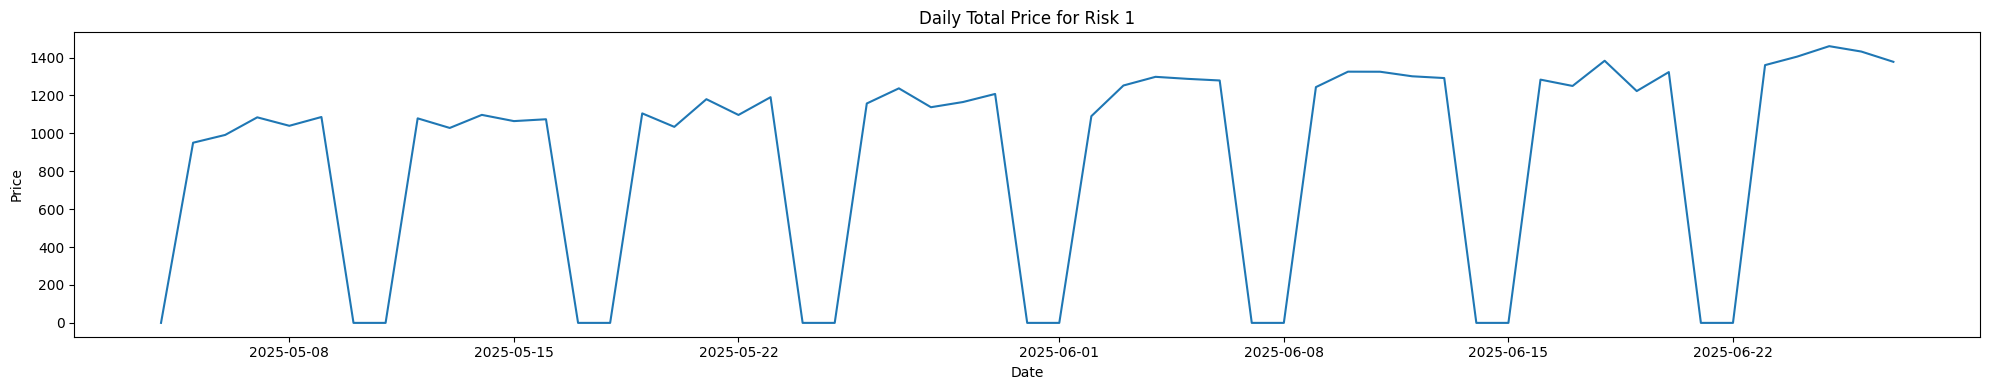

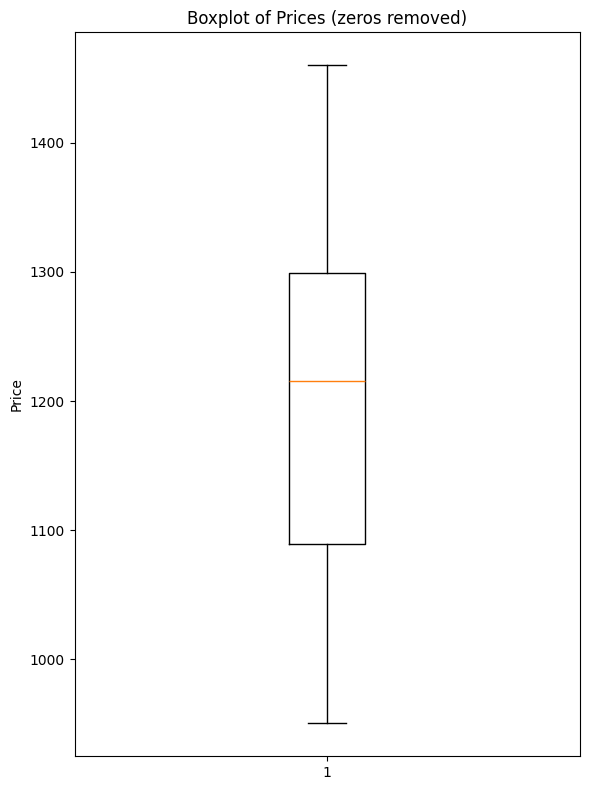

In [289]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime

print(df_risk1.head(10))
plt.figure(figsize=(20, 4))
plt.plot(df_risk1.index, df_risk1['price'])
plt.title("Daily Total Price for Risk 1")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

#outliers
df_nz = df_risk1[df_risk1['price'] != 0].copy()
plt.figure(figsize=(6, 8))
plt.boxplot(df_nz['price'], vert=True, showfliers=True)
plt.ylabel("Price")
plt.title("Boxplot of Prices (zeros removed)")
plt.tight_layout()
plt.show()

In [285]:
#Feature engineering

project_start_date = datetime.strptime("2025-05-04", "%Y-%m-%d")
project_end_date = datetime.strptime("2027-05-04", "%Y-%m-%d")
current_date = datetime.strptime("2025-06-27", "%Y-%m-%d")

days_for_training = pandas.date_range(start=project_start_date, end=current_date, freq='D')
days_to_predict = pandas.date_range(start=current_date, end=project_end_date, freq='D')
df_risk1 = df_risk1.reindex(days_for_training, fill_value=0)
df_risk1.index.name = 'date'

df_risk1['weekday'] = df_risk1.index.dayofweek

df_feat = df_risk1.copy().reset_index()
df_feat['is_saturday'] = (df_feat['weekday'] == 5).astype(int)
df_feat['is_sunday']   = (df_feat['weekday'] == 6).astype(int)
df_feat['dayofweek'] = df_feat['date'].dt.dayofweek
df_feat['quarter'] = df_feat['date'].dt.quarter
df_feat['month'] = df_feat['date'].dt.month
df_feat['year'] = df_feat['date'].dt.year
df_feat['dayofyear'] = df_feat['date'].dt.dayofyear
df_feat['dayofmonth'] = df_feat['date'].dt.day
df_feat['weekofyear'] = df_feat['date'].dt.isocalendar().week.astype(int)



x = df_feat.drop(columns=['price', 'date', 'risk_id','weekday'])
y = df_feat['price']

x_prediction = pandas.DataFrame(index=days_to_predict)
x_prediction.index.name = 'date'

idx = x_prediction.index

x_prediction['dayofweek']      = idx.dayofweek
x_prediction['is_saturday']  = (idx.dayofweek == 5).astype(int)
x_prediction['is_sunday']    = (idx.dayofweek == 6).astype(int)
x_prediction['quarter']      = idx.quarter
x_prediction['month']        = idx.month
x_prediction['year']         = idx.year
x_prediction['dayofyear']    = idx.dayofyear
x_prediction['dayofmonth']   = idx.day
x_prediction['weekofyear']   = idx.isocalendar().week.astype(int)


selected_featuers = ['dayofweek','is_saturday','is_sunday','weekofyear']

x = x[selected_featuers]
x_prediction = x_prediction[selected_featuers]



In [286]:
from xgboost import XGBRegressor
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    x, y
)

preds = model.predict(x_prediction)
forecast = pandas.Series(preds, index=x_prediction.index, name='predicted_price')

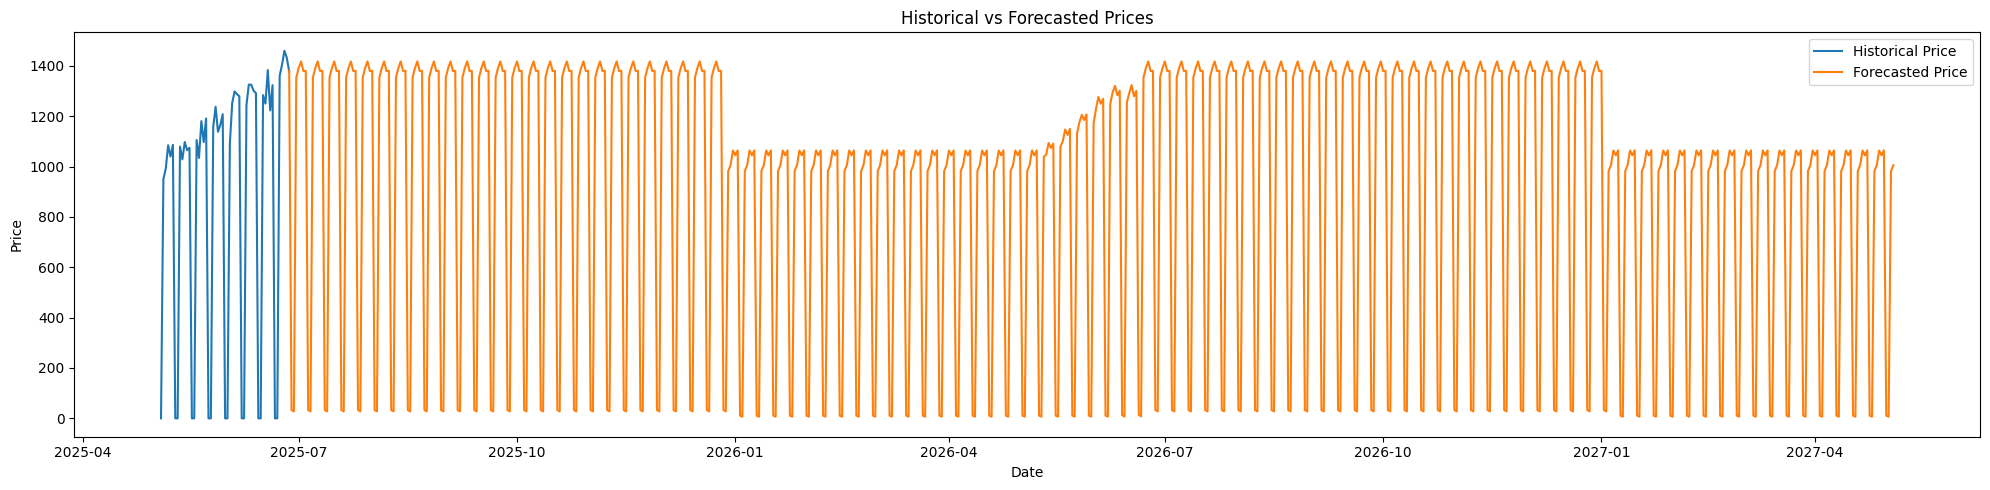

Total forecasted price: 602,858.81


In [287]:
#Graph
plt.figure(figsize=(20, 5))
plt.plot(df_feat['date'], df_feat['price'], label='Historical Price')
plt.plot(forecast.index,  forecast,           label='Forecasted Price')
plt.title('Historical vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

total_forecast = forecast.sum()

print(f"Total forecasted price: {total_forecast:,.2f}")